In [114]:
import pandas as pd
import joblib
import numpy as np

In [26]:
! pip install lightgbm

    100% |████████████████████████████████| 1.3MB 1.5MB/s eta 0:00:01
You are using pip version 9.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [60]:
train_df = pd.read_csv("train_data.csv")
train_df.shape

(1799805, 6)

In [61]:
train_df.head()

,date_hour,area_name,date_accident,hour_time,no_of_accidents,is_accident
0,2010-01-01 00:00:00,Olympic,2010-01-01 00:00:00,0,0.0,0
1,2010-01-01 01:00:00,Olympic,2010-01-01 00:00:00,100,1.0,1
2,2010-01-01 02:00:00,Olympic,2010-01-01 00:00:00,200,0.0,0
3,2010-01-01 03:00:00,Olympic,2010-01-01 00:00:00,300,1.0,1
4,2010-01-01 04:00:00,Olympic,2010-01-01 00:00:00,400,0.0,0


In [157]:
area_list = train_df['area_name'].to_list()

In [159]:
first = "blah"
for a in area_list:
    if a != first:
        print(a)
        first = a
    elif a == first:
        pass
    else:
        pass

Olympic
Southeast
Foothill
Hollywood
Mission
Northeast
Newton
Central
N Hollywood
Southwest
Harbor
Devonshire
Pacific
Rampart
Wilshire
77th Street
West LA
Topanga
Van Nuys
West Valley
Hollenbeck


In [62]:
#Baseline Prediction for majority classsifer
train_df['is_accident'].value_counts(normalize=True)

0    0.771062
1    0.228938
Name: is_accident, dtype: float64

# Will an accident happen in a area of Los Angeles in the next one hour


### Base Line Accuracy

##### With 77% accuracy we can predict that an accident will not happen in a area within the next one hour

##### As baseline accuracy is high, we will be using AUC ROC metric for Model performance of this classification problem

In [63]:
#Converting columns to datetime
train_df['date_hour']=pd.to_datetime(train_df['date_hour'])

In [64]:
area_names = train_df.area_name.unique()

In [65]:
area_names

array(['Olympic', 'Southeast', 'Foothill', 'Hollywood', 'Mission',
       'Northeast', 'Newton', 'Central', 'N Hollywood', 'Southwest',
       'Harbor', 'Devonshire', 'Pacific', 'Rampart', 'Wilshire',
       '77th Street', 'West LA', 'Topanga', 'Van Nuys', 'West Valley',
       'Hollenbeck'], dtype=object)

In [66]:
#Frequency of accidents in Los Angeles in any given hour
train_df['no_of_accidents'].value_counts(normalize=True)

0.0     7.710619e-01
1.0     1.896428e-01
2.0     3.343084e-02
3.0     5.037212e-03
4.0     7.050764e-04
5.0     9.667714e-05
6.0     1.777970e-05
7.0     4.444926e-06
8.0     1.666847e-06
14.0    5.556157e-07
12.0    5.556157e-07
11.0    5.556157e-07
Name: no_of_accidents, dtype: float64

In [67]:
#Creating features based on no of accidents happened in the past hours in that area
empty_df = []
laghours = [4,12,24,168,720,2880,8760]
for area in area_names:
    train_area = train_df[train_df.area_name==area].copy()
    train_area['no_past1hour']=train_df['no_of_accidents'].shift(1)
    for lhour in laghours:
        name = 'past_'+str(lhour)+'hours'
        train_area[name]=train_area['no_past1hour'].rolling(lhour).sum()
    empty_df.append(train_area)

In [68]:
#Final data after creating features
train = pd.concat(empty_df)
train.shape

(1799805, 14)

In [69]:
#Filling all Nan values with -1
train = train.fillna(-1)

In [70]:
#Adding more features to the data
#train['day']=train['date_hour'].dt.day
train['month']=train['date_hour'].dt.month
train['dayofweek']=train['date_hour'].dt.dayofweek
#train['year']=train['date_hour'].dt.year

In [71]:
#Removing No of accidents as that is a leakage feature and date_hour as it is equal to a index
train = train.drop(columns=['no_of_accidents'])
train.shape

(1799805, 15)

In [72]:
train.tail()

,date_hour,area_name,date_accident,hour_time,is_accident,no_past1hour,past_4hours,past_12hours,past_24hours,past_168hours,past_720hours,past_2880hours,past_8760hours,month,dayofweek
1799800,2019-10-11 20:00:00,Hollenbeck,2019-10-11 00:00:00,2000,0,0.0,0.0,0.0,2.0,28.0,155.0,641.0,2020.0,10,4
1799801,2019-10-11 21:00:00,Hollenbeck,2019-10-11 00:00:00,2100,0,0.0,0.0,0.0,2.0,28.0,155.0,640.0,2020.0,10,4
1799802,2019-10-11 22:00:00,Hollenbeck,2019-10-11 00:00:00,2200,0,0.0,0.0,0.0,2.0,28.0,155.0,640.0,2020.0,10,4
1799803,2019-10-11 23:00:00,Hollenbeck,2019-10-11 00:00:00,2300,0,0.0,0.0,0.0,2.0,28.0,154.0,640.0,2020.0,10,4
1799804,2019-10-12 00:00:00,Hollenbeck,2019-10-12 00:00:00,0,0,0.0,0.0,0.0,2.0,28.0,154.0,640.0,2020.0,10,5


In [73]:
#Creating a train,valid and test dataset based on time slicing
#Train set will be data before 2018
#Valid set will be data for year 2018
#Test set will be data for year 2019

In [74]:
target = 'is_accident'

In [75]:
train_set = train[train.date_hour<'2018-01-01']
valid_set = train[(train.date_hour>='2018-01-01')&(train.date_hour<'2019-01-01')]
test_set = train[train.date_hour>='2019-01-01']
print("Train :",train_set.shape[0])
print("Valid :",valid_set.shape[0])
print("Valid :",test_set.shape[0])

Train : 1472688
Valid : 183960
Valid : 143157


In [76]:
#separating target and training data
y_train = train_set[target]
train_set = train_set.drop(columns=target)
y_valid = valid_set[target]
valid_set = valid_set.drop(columns=target)
y_test = test_set[target]
test_set = test_set.drop(columns=target)

In [77]:
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report

In [78]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    #LGBMClassifier(max_depth=8,learning_rate=0.03,n_estimators=1500,min_child_samples=20)
)

In [160]:
joblib.dump(pipeline,'pipeline.joblib')

['pipeline.joblib']

In [128]:
features = train_set.columns.drop(['date_hour','date_accident','past_4hours', 'past_12hours',
       'past_24hours', 'past_168hours', 'past_720hours', 'past_2880hours',
       'past_8760hours','no_past1hour','month'])

In [129]:
features

Index(['area_name', 'hour_time', 'dayofweek'], dtype='object')

In [130]:
 X_train = pipeline.fit_transform(train_set[features])
 X_valid = pipeline.transform(valid_set[features])
 X_test = pipeline.transform(test_set[features])




In [161]:
pipeline

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['area_name'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'area_name',
                                          'data_type': dtype('O'),
                                          'mapping': Olympic         1
Southeast       2
Foothill        3
Hollywood       4
Mission         5
Northeast       6
Newton          7
Central         8
N Hollywood     9
Southwest      10
Harbor         11
Devonshire     12
Pacific        13
Rampart        14
Wilshire       15
77th Street    16
West LA        17
Topanga        18
Van Nuys       19
West Valley    20
Hollenbeck     21
NaN            -2
dtype: int64}],
                                return_df=True, verbose=0))],
         verbose=False)

In [148]:
train_set['area_name'].values

array(['Olympic', 'Olympic', 'Olympic', ..., 'Hollenbeck', 'Hollenbeck',
       'Hollenbeck'], dtype=object)

In [142]:
X_train

,area_name,hour_time,dayofweek
0,1,0,4
1,1,100,4
2,1,200,4
3,1,300,4
4,1,400,4
...,...,...,...
1784223,21,1900,6
1784224,21,2000,6
1784225,21,2100,6
1784226,21,2200,6


In [131]:
X_train.head()

,area_name,hour_time,dayofweek
0,1,0,4
1,1,100,4
2,1,200,4
3,1,300,4
4,1,400,4


In [132]:

eval_set = [(X_train,y_train),(X_valid,y_valid)]
model = LGBMClassifier(learning_rate=0.01,subsample= 1.0,
                      n_estimators = 500,min_child_weight = 3,
                       gamma =  1, colsample_bytree = 0.8)

In [164]:
X_train

,area_name,hour_time,dayofweek
0,1,0,4
1,1,100,4
2,1,200,4
3,1,300,4
4,1,400,4
...,...,...,...
1784223,21,1900,6
1784224,21,2000,6
1784225,21,2100,6
1784226,21,2200,6


In [166]:
model.fit(X_train,y_train,eval_set=eval_set,eval_metric='auc',
                      early_stopping_rounds=50)

[1]	valid_0's auc: 0.554746	valid_0's binary_logloss: 0.531746	valid_1's auc: 0.548877	valid_1's binary_logloss: 0.569038
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.650345	valid_0's binary_logloss: 0.531288	valid_1's auc: 0.651022	valid_1's binary_logloss: 0.56853
[3]	valid_0's auc: 0.650879	valid_0's binary_logloss: 0.530838	valid_1's auc: 0.652836	valid_1's binary_logloss: 0.568033
[4]	valid_0's auc: 0.650418	valid_0's binary_logloss: 0.530776	valid_1's auc: 0.651107	valid_1's binary_logloss: 0.567972
[5]	valid_0's auc: 0.646508	valid_0's binary_logloss: 0.530715	valid_1's auc: 0.646184	valid_1's binary_logloss: 0.567913
[6]	valid_0's auc: 0.659139	valid_0's binary_logloss: 0.53023	valid_1's auc: 0.659863	valid_1's binary_logloss: 0.567378
[7]	valid_0's auc: 0.657043	valid_0's binary_logloss: 0.530171	valid_1's auc: 0.65701	valid_1's binary_logloss: 0.56732
[8]	valid_0's auc: 0.657383	valid_0's binary_logloss: 0.529739	valid_1's auc: 0.658117	va

[69]	valid_0's auc: 0.663944	valid_0's binary_logloss: 0.51573	valid_1's auc: 0.665027	valid_1's binary_logloss: 0.55152
[70]	valid_0's auc: 0.663845	valid_0's binary_logloss: 0.515526	valid_1's auc: 0.664972	valid_1's binary_logloss: 0.551292
[71]	valid_0's auc: 0.663889	valid_0's binary_logloss: 0.515288	valid_1's auc: 0.665011	valid_1's binary_logloss: 0.551031
[72]	valid_0's auc: 0.663827	valid_0's binary_logloss: 0.51509	valid_1's auc: 0.664976	valid_1's binary_logloss: 0.550811
[73]	valid_0's auc: 0.663723	valid_0's binary_logloss: 0.514896	valid_1's auc: 0.664905	valid_1's binary_logloss: 0.550595
[74]	valid_0's auc: 0.663644	valid_0's binary_logloss: 0.514706	valid_1's auc: 0.664848	valid_1's binary_logloss: 0.550383
[75]	valid_0's auc: 0.663561	valid_0's binary_logloss: 0.514516	valid_1's auc: 0.664792	valid_1's binary_logloss: 0.550174
[76]	valid_0's auc: 0.66365	valid_0's binary_logloss: 0.514485	valid_1's auc: 0.664812	valid_1's binary_logloss: 0.550146
[77]	valid_0's auc: 

[137]	valid_0's auc: 0.664978	valid_0's binary_logloss: 0.507598	valid_1's auc: 0.665748	valid_1's binary_logloss: 0.54271
[138]	valid_0's auc: 0.665015	valid_0's binary_logloss: 0.507482	valid_1's auc: 0.665787	valid_1's binary_logloss: 0.542584
[139]	valid_0's auc: 0.665049	valid_0's binary_logloss: 0.507367	valid_1's auc: 0.665824	valid_1's binary_logloss: 0.54246
[140]	valid_0's auc: 0.665033	valid_0's binary_logloss: 0.50728	valid_1's auc: 0.665807	valid_1's binary_logloss: 0.542365
[141]	valid_0's auc: 0.665069	valid_0's binary_logloss: 0.507262	valid_1's auc: 0.665814	valid_1's binary_logloss: 0.54235
[142]	valid_0's auc: 0.6651	valid_0's binary_logloss: 0.50715	valid_1's auc: 0.665855	valid_1's binary_logloss: 0.542229
[143]	valid_0's auc: 0.665135	valid_0's binary_logloss: 0.507133	valid_1's auc: 0.665855	valid_1's binary_logloss: 0.542214
[144]	valid_0's auc: 0.665166	valid_0's binary_logloss: 0.507024	valid_1's auc: 0.665888	valid_1's binary_logloss: 0.542096
[145]	valid_0's

[206]	valid_0's auc: 0.666131	valid_0's binary_logloss: 0.504156	valid_1's auc: 0.666566	valid_1's binary_logloss: 0.539076
[207]	valid_0's auc: 0.666127	valid_0's binary_logloss: 0.504109	valid_1's auc: 0.666566	valid_1's binary_logloss: 0.539023
[208]	valid_0's auc: 0.66614	valid_0's binary_logloss: 0.5041	valid_1's auc: 0.66657	valid_1's binary_logloss: 0.539016
[209]	valid_0's auc: 0.666134	valid_0's binary_logloss: 0.504054	valid_1's auc: 0.666556	valid_1's binary_logloss: 0.538965
[210]	valid_0's auc: 0.666123	valid_0's binary_logloss: 0.504008	valid_1's auc: 0.666558	valid_1's binary_logloss: 0.538916
[211]	valid_0's auc: 0.666151	valid_0's binary_logloss: 0.503942	valid_1's auc: 0.666578	valid_1's binary_logloss: 0.538847
[212]	valid_0's auc: 0.66615	valid_0's binary_logloss: 0.503898	valid_1's auc: 0.666587	valid_1's binary_logloss: 0.538798
[213]	valid_0's auc: 0.666143	valid_0's binary_logloss: 0.503855	valid_1's auc: 0.66658	valid_1's binary_logloss: 0.538751
[214]	valid_0'

[273]	valid_0's auc: 0.66683	valid_0's binary_logloss: 0.502061	valid_1's auc: 0.667052	valid_1's binary_logloss: 0.536909
[274]	valid_0's auc: 0.666827	valid_0's binary_logloss: 0.502038	valid_1's auc: 0.66705	valid_1's binary_logloss: 0.536884
[275]	valid_0's auc: 0.666846	valid_0's binary_logloss: 0.502001	valid_1's auc: 0.667064	valid_1's binary_logloss: 0.536847
[276]	valid_0's auc: 0.666858	valid_0's binary_logloss: 0.501996	valid_1's auc: 0.667064	valid_1's binary_logloss: 0.536844
[277]	valid_0's auc: 0.666853	valid_0's binary_logloss: 0.501974	valid_1's auc: 0.667066	valid_1's binary_logloss: 0.53682
[278]	valid_0's auc: 0.666874	valid_0's binary_logloss: 0.501938	valid_1's auc: 0.667084	valid_1's binary_logloss: 0.536783
[279]	valid_0's auc: 0.666898	valid_0's binary_logloss: 0.501902	valid_1's auc: 0.667102	valid_1's binary_logloss: 0.536748
[280]	valid_0's auc: 0.666898	valid_0's binary_logloss: 0.501881	valid_1's auc: 0.667101	valid_1's binary_logloss: 0.536725
[281]	valid

[340]	valid_0's auc: 0.667396	valid_0's binary_logloss: 0.500921	valid_1's auc: 0.667371	valid_1's binary_logloss: 0.535796
[341]	valid_0's auc: 0.667402	valid_0's binary_logloss: 0.500918	valid_1's auc: 0.667368	valid_1's binary_logloss: 0.535795
[342]	valid_0's auc: 0.667408	valid_0's binary_logloss: 0.500915	valid_1's auc: 0.667365	valid_1's binary_logloss: 0.535795
[343]	valid_0's auc: 0.66741	valid_0's binary_logloss: 0.500904	valid_1's auc: 0.667372	valid_1's binary_logloss: 0.535782
[344]	valid_0's auc: 0.667411	valid_0's binary_logloss: 0.500891	valid_1's auc: 0.667366	valid_1's binary_logloss: 0.53577
[345]	valid_0's auc: 0.667412	valid_0's binary_logloss: 0.50088	valid_1's auc: 0.667365	valid_1's binary_logloss: 0.535758
[346]	valid_0's auc: 0.667417	valid_0's binary_logloss: 0.500877	valid_1's auc: 0.667364	valid_1's binary_logloss: 0.535757
[347]	valid_0's auc: 0.667436	valid_0's binary_logloss: 0.500856	valid_1's auc: 0.667375	valid_1's binary_logloss: 0.535737
[348]	valid

[408]	valid_0's auc: 0.667874	valid_0's binary_logloss: 0.500276	valid_1's auc: 0.66764	valid_1's binary_logloss: 0.535212
[409]	valid_0's auc: 0.667885	valid_0's binary_logloss: 0.500263	valid_1's auc: 0.667642	valid_1's binary_logloss: 0.535201
[410]	valid_0's auc: 0.667887	valid_0's binary_logloss: 0.500256	valid_1's auc: 0.667647	valid_1's binary_logloss: 0.535194
[411]	valid_0's auc: 0.667896	valid_0's binary_logloss: 0.500244	valid_1's auc: 0.667653	valid_1's binary_logloss: 0.535182
[412]	valid_0's auc: 0.667903	valid_0's binary_logloss: 0.500237	valid_1's auc: 0.667657	valid_1's binary_logloss: 0.535175
[413]	valid_0's auc: 0.667911	valid_0's binary_logloss: 0.500229	valid_1's auc: 0.66766	valid_1's binary_logloss: 0.535169
[414]	valid_0's auc: 0.667921	valid_0's binary_logloss: 0.500217	valid_1's auc: 0.667665	valid_1's binary_logloss: 0.535158
[415]	valid_0's auc: 0.667924	valid_0's binary_logloss: 0.500215	valid_1's auc: 0.667663	valid_1's binary_logloss: 0.535157
[416]	vali

[475]	valid_0's auc: 0.668277	valid_0's binary_logloss: 0.499857	valid_1's auc: 0.667882	valid_1's binary_logloss: 0.534844
[476]	valid_0's auc: 0.668286	valid_0's binary_logloss: 0.499849	valid_1's auc: 0.667889	valid_1's binary_logloss: 0.534838
[477]	valid_0's auc: 0.668296	valid_0's binary_logloss: 0.499842	valid_1's auc: 0.667895	valid_1's binary_logloss: 0.534832
[478]	valid_0's auc: 0.668301	valid_0's binary_logloss: 0.499838	valid_1's auc: 0.667897	valid_1's binary_logloss: 0.534828
[479]	valid_0's auc: 0.66831	valid_0's binary_logloss: 0.49983	valid_1's auc: 0.667901	valid_1's binary_logloss: 0.534822
[480]	valid_0's auc: 0.668313	valid_0's binary_logloss: 0.499826	valid_1's auc: 0.667908	valid_1's binary_logloss: 0.534817
[481]	valid_0's auc: 0.668321	valid_0's binary_logloss: 0.499818	valid_1's auc: 0.667914	valid_1's binary_logloss: 0.534811
[482]	valid_0's auc: 0.668331	valid_0's binary_logloss: 0.499812	valid_1's auc: 0.667921	valid_1's binary_logloss: 0.534806
[483]	vali

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               gamma=1, importance_type='split', learning_rate=0.01,
               max_depth=-1, min_child_samples=20, min_child_weight=3,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [167]:
joblib.dump(model,'logistic.joblib')

['logistic.joblib']

In [165]:
X_train.columns

Index(['area_name', 'hour_time', 'dayofweek'], dtype='object')

In [134]:
#roc auc score for valid set
roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])

0.6679826032443535

In [135]:
#roc auc score for test set
roc_auc_score(y_test,model.predict_proba(X_test)[:,1])

0.6666336005123636

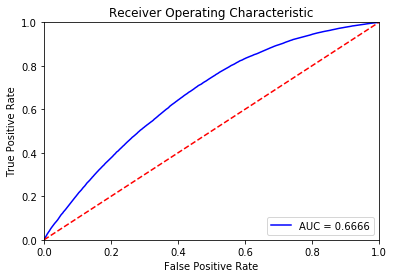

In [136]:
#ROC AUC Curve plotting
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [137]:
confusion_matrix(y_test,model.predict(X_test))

array([[107570,      0],
       [ 35587,      0]])

In [138]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86    107570
           1       0.00      0.00      0.00     35587

    accuracy                           0.75    143157
   macro avg       0.38      0.50      0.43    143157
weighted avg       0.56      0.75      0.64    143157



/home/rob/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [163]:
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               gamma=1, importance_type='split', learning_rate=0.01,
               max_depth=-1, min_child_samples=20, min_child_weight=3,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [139]:
joblib.dump(model,'logistic.joblib')

['logistic.joblib']

In [140]:
X_test.columns

Index(['area_name', 'hour_time', 'dayofweek'], dtype='object')

In [141]:
area_name

NameError: name 'area_name' is not defined

In [ ]:
prediction =[3,'300','4','6']
prediction = np.array(np.array(prediction).reshape(1,-1))

In [ ]:
model.predict_proba(prediction)